In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
BATCH_SIZE = 32
IMAGE_SIZEx = 256
IMAGE_SIZEy=256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\lokes\coding filess\PYTHON\projects\coffee leaf detection using cnn\archive\train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZEx,IMAGE_SIZEy),
    batch_size=BATCH_SIZE
)

Found 1264 files belonging to 4 classes.


In [4]:
dataset.class_names


['miner', 'nodisease', 'phoma', 'rust']

In [59]:
class_names = dataset.class_names
class_names

['miner', 'nodisease', 'phoma', 'rust']

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds
print(len(train_ds),len(val_ds),len(test_ds))

32 4 4


In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
from tensorflow.keras import models, layers

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZEx, IMAGE_SIZEy),
    layers.Rescaling(1./255),
])


# Ensembling the Models


In [21]:

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])


In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [43]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

# Create the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZEx, IMAGE_SIZEx, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add a new classification head
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(10, activation='softmax')(x)

# Create the new model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [44]:
model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1024)           │    33,555,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,280,394 (184.18 MB)

 Trainable params: 33,565,706 (128.04 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [45]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 158s 5s/step - accuracy: 0.4191 - loss: 75.1165 - val_accuracy: 0.7500 - val_loss: 29.2465
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 162s 5s/step - accuracy: 0.7498 - loss: 24.1272 - val_accuracy: 0.8281 - val_loss: 14.8264
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 161s 5s/step - accuracy: 0.8390 - loss: 12.4524 - val_accuracy: 0.8125 - val_loss: 15.3174
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 173s 5s/step - accuracy: 0.8356 - loss: 12.6060 - val_accuracy: 0.7188 - val_loss: 29.6964
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 166s 5s/step - accuracy: 0.8108 - loss: 15.8016 - val_accuracy: 0.9141 - val_loss: 3.7070
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 162s 5s/step - accuracy: 0.8704 - loss: 7.1852 - val_accuracy: 0.9297 - val_loss: 3.2208
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 158s 5s/step - accuracy: 0.8606 - loss: 7.2663 - val_accuracy: 0.9141 - val_loss: 4.7341
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 153s 5s/step - accuracy: 0.9054 - loss: 4.6242 - val_accuracy: 0

In [46]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 32}

In [47]:
history.history.keys()


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [48]:
scores = model.evaluate(test_ds)
scores


4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.9937 - loss: 0.2490  


[0.6225097179412842, 0.984375]

### Model History Visualisation

Text(0.5, 1.0, 'accuracy Plot')

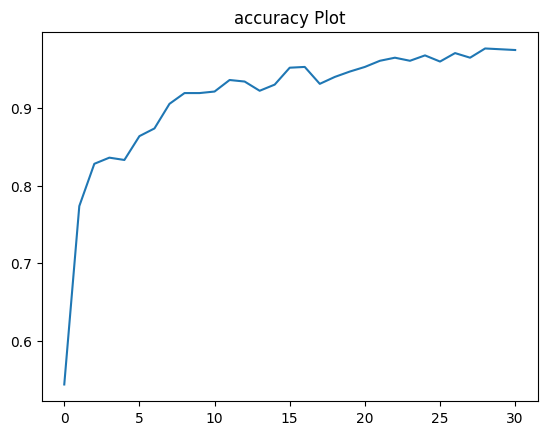

In [51]:
import pandas as pd
plt.plot(pd.DataFrame(history.history)['accuracy'])
plt.title("accuracy Plot")

Text(0.5, 1.0, 'Loss Plot')

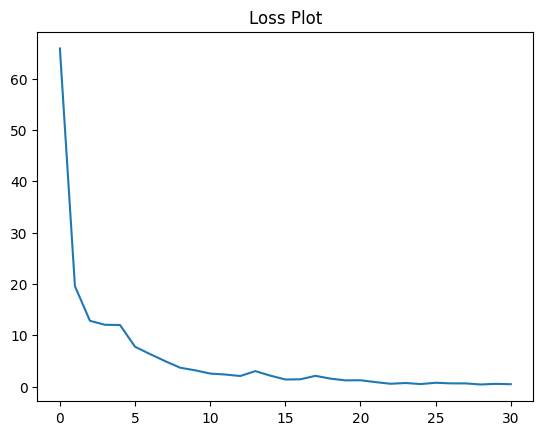

In [52]:
plt.plot(pd.DataFrame(history.history)['loss'])
plt.title("Loss Plot")

Text(0.5, 1.0, 'Validation Accuracy Plot')

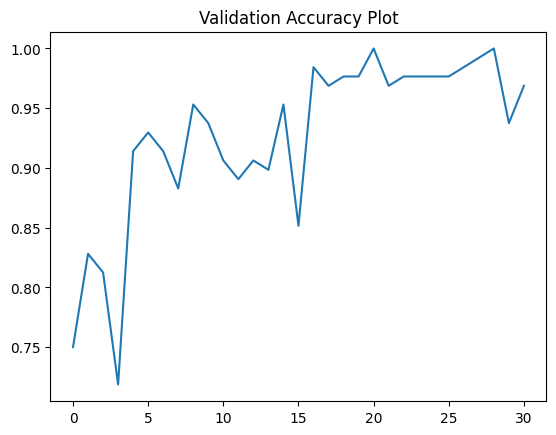

In [53]:
plt.plot(pd.DataFrame(history.history)['val_accuracy'])
plt.title("Validation Accuracy Plot")

Text(0.5, 1.0, 'Validation Accuracy Plot')

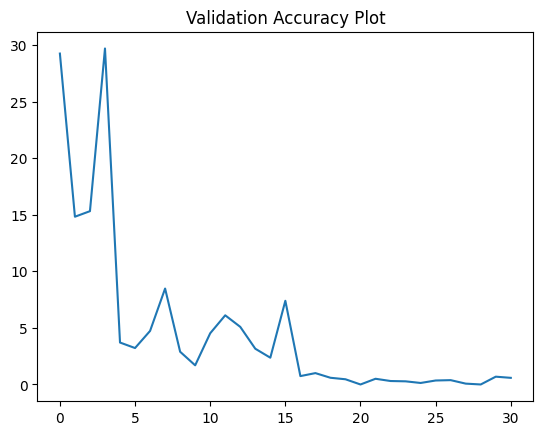

In [54]:
plt.plot(pd.DataFrame(history.history)['val_loss'])
plt.title("Validation Accuracy Plot")

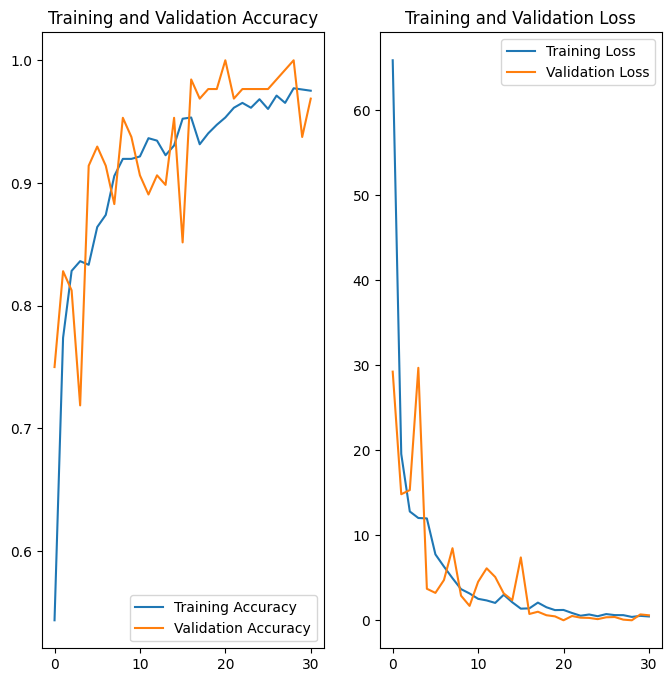

In [57]:
# Pad the shorter list with None values to match the length of the longer list
max_len = max(len(acc), len(val_acc))
acc.extend([None] * (max_len - len(acc)))
val_acc.extend([None] * (max_len - len(val_acc)))

# Plot the accuracy curves
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(max_len), acc, label='Training Accuracy')
plt.plot(range(max_len), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(max_len), loss, label='Training Loss')
plt.plot(range(max_len), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: miner
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
predicted label: miner


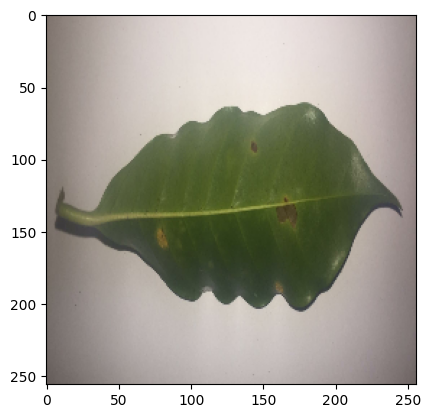

In [60]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [61]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


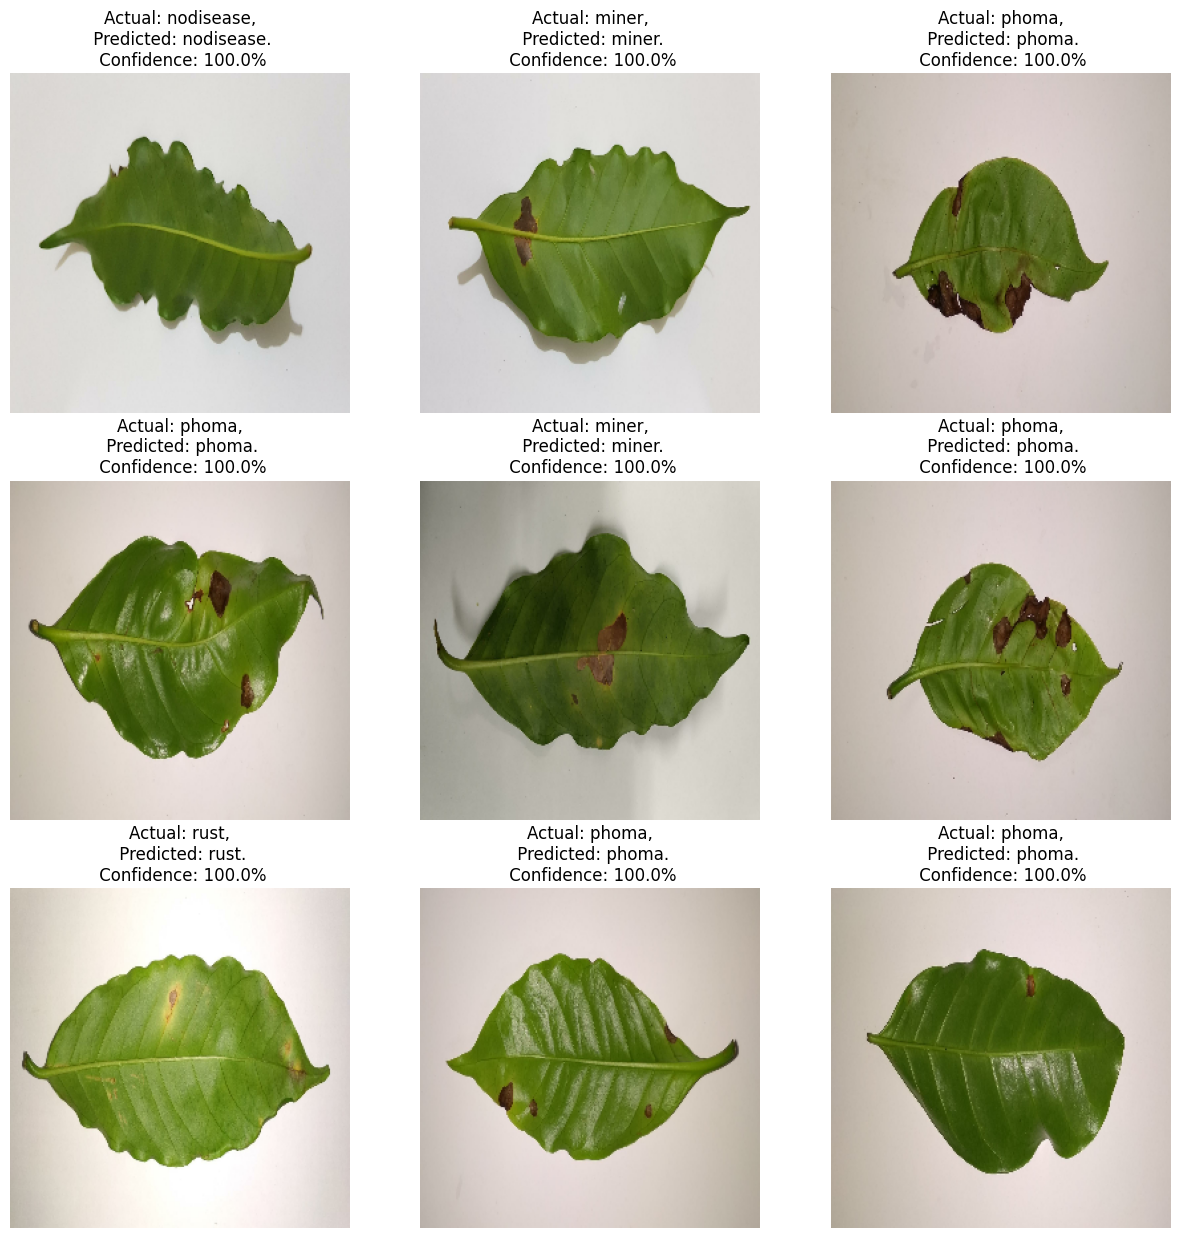

In [62]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [64]:
model_version = 20
model.save(r"C:\Users\lokes\Desktop\coffee_leaf_detection\model_{}.h5".format(model_version))